# Inference script

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import save_image
import os
from PIL import Image
import numpy as np
import json

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
image_size = 256
nz = 100  # Size of z latent vector
nc = 3    # Number of channels in the images
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
num_epochs = 100
lr = 0.0002
beta1 = 0.5
embedding_dim = 100  # Dimension of text embeddings

# Generator Model
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, embedding_dim):
        super(Generator, self).__init__()
        self.text = nn.Linear(embedding_dim, nz)  # Embedding layer for text
        # Initialize the modules to be used in the generator network.
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz * 2, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, ngf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf // 2),
            nn.ReLU(True),
            # state size. (ngf/2) x 128 x 128
            nn.ConvTranspose2d(ngf // 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, noise, text_embedding):
        # Process the text embedding to produce outputs matching the noise tensor dimensions
        text_embedding = self.text(text_embedding)
        # Ensure that text_embedding has the same total elements as noise for each example in the batch
        text_embedding = text_embedding.view(noise.size(0), nz, 1, 1)  # Correctly reshaping

        # Concatenate noise and text embeddings along channel dimension
        combined_input = torch.cat([noise, text_embedding], 1)
        return self.main(combined_input)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, ndf, nc, image_size, embedding_dim):
        super(Discriminator, self).__init__()
        self.text = nn.Linear(embedding_dim, image_size * image_size)  # Convert text embedding into spatial format
        self.main = nn.Sequential(
            # Input is (nc + 1) x 256 x 256
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 128 x 128
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*32) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output a single scalar between 0 and 1
        )

    def forward(self, image, text_embedding):
        # Resize and inject text embedding into the image channel dimension
        text_embedding = self.text(text_embedding).view(-1, 1, image_size, image_size)
        # Concatenate along the channel dimension
        input = torch.cat([image, text_embedding], 1)
        return self.main(input).view(-1)  # Flatten the output to a single dimension per batch

# Generate Bulk Images

In [2]:
import os

# Load pre-trained Generator
netG = Generator(nz, ngf, nc, embedding_dim).to(device)
netG.load_state_dict(torch.load('generator.pth', map_location=device))
netG.eval()

def generate_image_from_text(text, output_filename):
    """Generate an image from text and save it to the specified filename."""
    # Convert text to embedding (simplified one-hot encoding as an example)
    tag_embedding = torch.zeros(embedding_dim)
    words = text.split()
    for word in words:
        index = abs(hash(word)) % embedding_dim
        tag_embedding[index] = 1

    # Generate noise vector
    noise = torch.randn(1, nz, 1, 1, device=device)
    tag_embedding = tag_embedding.to(device).unsqueeze(0)  # Add batch dimension

    # Generate image
    with torch.no_grad():
        fake_image = netG(noise, tag_embedding)
    
    # Convert image tensor to PIL Image and save
    fake_image = (fake_image * 0.5 + 0.5)  # Unnormalize
    img = transforms.ToPILImage()(fake_image.squeeze(0).cpu())
    img.save(output_filename)

def process_directory(text_dir, output_dir, max_images=None):
    """Process the directory of text files and generate images."""
    texts = [f for f in os.listdir(text_dir) if f.endswith('.txt')]
    if max_images is not None:
        texts = texts[:max_images]

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, filename in enumerate(texts):
        with open(os.path.join(text_dir, filename), 'r') as file:
            text = file.read()
        output_filename = os.path.join(output_dir, f'generated_image_{i}.png')
        generate_image_from_text(text, output_filename)
        print(f"Generated image saved to {output_filename}")

# User inputs
text_dir = 'texts'
output_dir = 'generated_images'
max_images = None  # Set to None to process all texts or an integer to specify a number of files

process_directory(text_dir, output_dir, max_images)
print("All images generated.")

Generated image saved to generated_images\generated_image_0.png
Generated image saved to generated_images\generated_image_1.png
Generated image saved to generated_images\generated_image_2.png
Generated image saved to generated_images\generated_image_3.png
Generated image saved to generated_images\generated_image_4.png
Generated image saved to generated_images\generated_image_5.png
Generated image saved to generated_images\generated_image_6.png
Generated image saved to generated_images\generated_image_7.png
Generated image saved to generated_images\generated_image_8.png
Generated image saved to generated_images\generated_image_9.png
Generated image saved to generated_images\generated_image_10.png
Generated image saved to generated_images\generated_image_11.png
Generated image saved to generated_images\generated_image_12.png
Generated image saved to generated_images\generated_image_13.png
Generated image saved to generated_images\generated_image_14.png
Generated image saved to generated_

# Generate 5 versions against a user input text

Image saved as generated_image_0.png


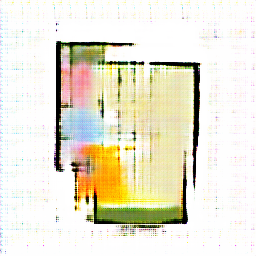

Image saved as generated_image_1.png


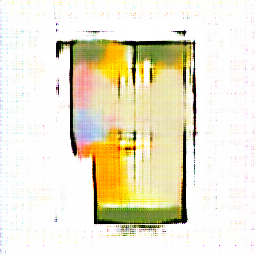

Image saved as generated_image_2.png


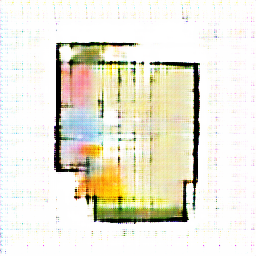

Image saved as generated_image_3.png


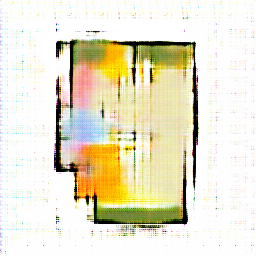

Image saved as generated_image_4.png


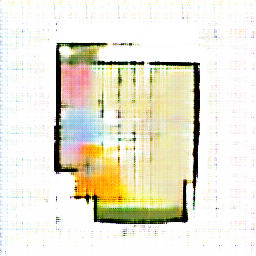

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import os
from IPython.display import display  # For displaying images in Jupyter notebooks

# Assume Generator, device, nz, ngf, nc, embedding_dim are properly defined/imported above
# Load pre-trained Generator
netG = Generator(nz, ngf, nc, embedding_dim).to(device)
netG.load_state_dict(torch.load('generator.pth', map_location=device))
netG.eval()

# Function to generate and save an image from text
def generate_image_from_text(text, image_number):
    # Convert text to embedding (simplified one-hot encoding as an example)
    tag_embedding = torch.zeros(embedding_dim)
    words = text.split()
    for word in words:
        index = abs(hash(word)) % embedding_dim
        tag_embedding[index] = 1

    # Generate noise vector
    noise = torch.randn(1, nz, 1, 1, device=device)
    tag_embedding = tag_embedding.to(device).unsqueeze(0)  # Add batch dimension

    # Generate image
    with torch.no_grad():
        fake_image = netG(noise, tag_embedding)
    
    # Convert image tensor to PIL Image and unnormalize
    fake_image = (fake_image * 0.5 + 0.5)  # unnormalize
    img = transforms.ToPILImage()(fake_image.squeeze(0).cpu())

    # Save the image with a unique name
    output_filename = f'generated_image_{image_number}.png'
    img.save(output_filename)
    print(f"Image saved as {output_filename}")

    # Display the image (optional, comment out if running outside Jupyter)
    display(img)

# User input for text description and number of images
desc = input("Enter text description: ")
num = int(input("Enter number of images to generate for the entered description: "))

# Generate the specified number of images
for i in range(num):
    generate_image_from_text(desc, i)

#Balcony Room Located on North east corner with master Room on below , Total size of 11 Feet length and 3 Feet Width. bath Room Located on exact south center of the plan with com Room on right , Total size of 7 Feet length and 3 Feet Width. com Room Located on South east corner with master Room on above , Total size of 13 Feet length and 9 Feet Width. Kitchen Room Located on North west corner with balcony Room on right , Total size of 10 Feet length and 2 Feet Width. Living Room Located on covered entire west area with kitchen Room on above , Total size of 20 Feet length and 18 Feet Width. Master Room Located on North east side with balcony Room on above , Total size of 12 Feet length and 12 Feet Width. 